In [1]:
!pip install -Uqq fastcore datasets fastprogress

## Import code from miniai

Code from miniai.training

In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Code from miniai.datasets

In [3]:
from __future__ import annotations
import math,numpy as np,matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate

def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

Code from miniai.conv

In [4]:
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b): return to_device(default_collate(b))

___

## Autoencoders

In [5]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore as fcore # changed alias from 'fc' to 'fcore', as 'fc' was giving conflicts, which broke 'show_image'
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar

In [6]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

### Data

In [7]:
x,y = 'image','label'
name = 'fashion_mnist'
dsd = load_dataset(name, ignore_verifications=True)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Note Umer: I can use `HuggingFace Datasets` to quickly get common datasets. Cool!

In [8]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [9]:
bs = 256
tds = dsd.with_transform(transformi)

In [10]:
tds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

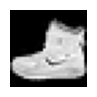

In [11]:
ds = tds['train']
img= ds[0]['image']
show_image(img, figsize=(1,1));

In [12]:
cf = collate_dict(ds)

In [13]:
collate_dict??

Signature: collate_dict(ds)
Docstring: <no docstring>
Source:   
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f
File:      /tmp/ipykernel_28/1507025354.py
Type:      function

Note Umer: `cf` is a collate function with the keys of the the passed dataset dict

In [14]:
def collate_(b): return to_device(cf(b))
def data_loaders(dsd,bs,**kwargs): return {
    k:DataLoader(v,bs,**kwargs)
    for k,v in dsd.items()
}

In [15]:
dls = data_loaders(tds,bs,collate_fn=collate_)

In [16]:
dt = dls['train']
dv = dls['test']

xb,yb = next(iter(dt))

In [17]:
labels = ds.features[y]
labels

ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [18]:
labels = ds.features[y].names
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [19]:
print([*yb[:16]])
lbl_getter = itemgetter(*yb[:16])

titles = lbl_getter(labels)
print(titles)

[tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(7, device='cuda:0'), tensor(2, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(7, device='cuda:0'), tensor(9, device='cuda:0')]
('Ankle boot', 'T - shirt / top', 'T - shirt / top', 'Dress', 'T - shirt / top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal', 'T - shirt / top', 'Ankle boot', 'Sandal', 'Sandal', 'Sneaker', 'Ankle boot')


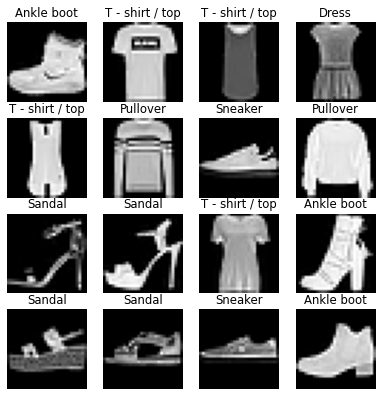

In [20]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

## Warmum - classify

In [21]:
from torch import optim

bs = 256
lr = 0.4

In [22]:
cnn = nn.Sequential(
    conv(1,4),            # 14x14
    conv(4,8),            # 7,7
    conv(8,16),           # 4x4
    conv(16,16),          # 2x2
    conv(16,10,act=True), # 1x1    
    nn.Flatten()
).to(def_device)

In [23]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss,acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0 2.302584887313843 0.1
1 2.302584887313843 0.1
2 2.302584887313843 0.1
3 2.302584887313843 0.1
4 2.302584887313843 0.1


In [24]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

## Autoencoder

In [25]:
def deconv(ni, nf, ks=3, act=True):
    layers = [
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(ni, nf, stride=1, kernel_size=3, padding=ks//2)
    ]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

Note Umer: The deconv block
1. upscales naively, ie, each pixel is duplicates 2x2=4 times
2. applies a conv with stride=1 & appropriate padding (ie s.t. size remains same)

In [26]:
def eval_ae(model, loss_func, valid_dl,epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        # Note Umer: we're not using yb, as we're building an auto-encoder, where xb is the target
        for xb,_ in valid_dl:
            n = len(xb)
            tot_loss += loss_func(model(xb),xb).item()*n
            count += n
    print(epoch, f'{tot_loss/count:.3f}')

**Q:** Why do we need `mode.eval()`? We're not using any architecture that behave differently during training / inference (like e.g dropout).

In [27]:
def fit_ae(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            loss = loss_func(model(xb),xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval_ae(model,loss_func,valid_dl,epoch)

In [28]:
ae = nn.Sequential(        # 28x28
    nn.ZeroPad2d(2),       # 32x32
    conv(1,2),             # 16x16
    conv(2,4),             # 8x8
    deconv(4,2),           # 16x16
    deconv(2,1,act=False), # 32x32
    nn.ZeroPad2d(-2),      # 28x28
    nn.Sigmoid()
).to(def_device)

In [29]:
eval_ae(ae, F.mse_loss, dv)

0 0.182


**Q:** As the nn is currently random, I would have expected the  mse to be closer to 0.5.

**A:** The code below shows that the mse between 2 U(0,1)-random distributed variables is actually ~0.17, not 0.5!

In [30]:
rng = torch.linspace(0,1,100)
sum([(i-j)**2 for i in rng for j in rng])/(100*100)

tensor(0.17)

In [31]:
opt = optim.SGD(ae.parameters(), lr=0.01)
fit_ae(5, ae, F.mse_loss, opt, dt, dv)

0 0.154
1 0.139
2 0.130
3 0.126
4 0.125


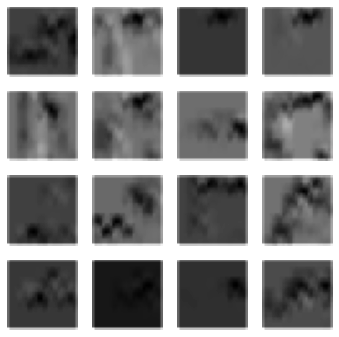

In [32]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

**Q:** These are crap! Why? Also, Jeremy's ae had loss of 0.034, not 0.125.<br/>
**A:** Jeremy first trained with `lr=0.01`, but then also with `lr=0.1`.

In [35]:
opt = optim.SGD(ae.parameters(), lr=0.1)
fit_ae(5, ae, F.mse_loss, opt, dt, dv)

0 0.125
1 0.124
2 0.124
3 0.124
4 0.124


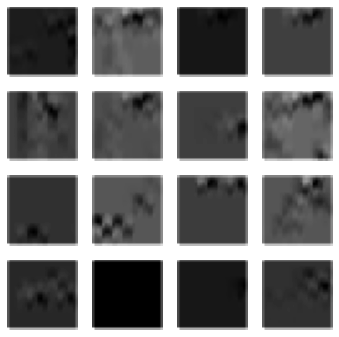

In [36]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

Still look like crap.

Let'do some experimentation

In [37]:
def get_ae():
    return nn.Sequential(      # 28x28
        nn.ZeroPad2d(2),       # 32x32
        conv(1,2),             # 16x16
        conv(2,4),             # 8x8
        deconv(4,2),           # 16x16
        deconv(2,1,act=False), # 32x32
        nn.ZeroPad2d(-2),      # 28x28
        nn.Sigmoid()
    ).to(def_device)

In [40]:
def create_and_fit(epochs, lr):
    ae = get_ae()
    opt = optim.SGD(ae.parameters(), lr=lr)
    fit_ae(epochs, ae, F.mse_loss, opt, dt, dv)

In [41]:
create_and_fit(5, lr=0.1)

0 0.125
1 0.124
2 0.124
3 0.124
4 0.124


In [42]:
create_and_fit(5, lr=0.05)

0 0.124
1 0.124
2 0.124
3 0.124
4 0.124


In [43]:
create_and_fit(20, lr=0.01)

0 0.162
1 0.146
2 0.137
3 0.132
4 0.129
5 0.127
6 0.126
7 0.125
8 0.125
9 0.125
10 0.125
11 0.124
12 0.124
13 0.124
14 0.124
15 0.124
16 0.124
17 0.124
18 0.124
19 0.124


**Q:** This ae seems to peak at `mse=0.124`, while Jeremy's ae gets to `0.03`. Why?<br/>
**A:** It's randomnes - see below.

**Edit:** On JarvisLabs, the model trained with `lr=0.1` trains well. Let's train it again a few times. Maybe the bad performance is just randomness. Let's train again a few times.

In [45]:
def create_and_fit(epochs, lr):
    ae = get_ae()
    opt = optim.SGD(ae.parameters(), lr=lr)
    fit_ae(epochs, ae, F.mse_loss, opt, dt, dv)
    return ae

In [46]:
aes = []
for i in range(5):
    print(f'-- Training model {i}')
    aes.append(create_and_fit(5, lr=0.1))

-- Training model 0
0 0.056
1 0.037
2 0.032
3 0.029
4 0.027
-- Training model 1
0 0.112
1 0.039
2 0.032
3 0.029
4 0.027
-- Training model 2
0 0.044
1 0.032
2 0.028
3 0.026
4 0.024
-- Training model 3
0 0.028
1 0.026
2 0.024
3 0.023
4 0.021
-- Training model 4
0 0.124
1 0.124
2 0.124
3 0.124
4 0.124


Interesting! It is really just randomness. 4 out of 6 times (5 now, 1 above),the model trained. 2 out of 6 times, it failed.

In [47]:
def show_ae_images(ae_model):
    p = ae_model(xb)
    show_images(p[:16].data.cpu(), imsize=1.5)

Model 0 with val loss = 0.027


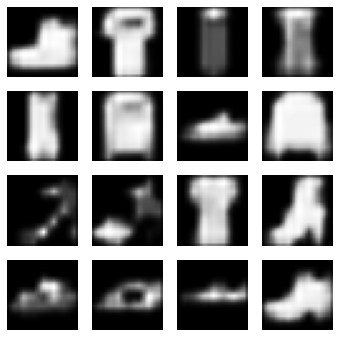

In [52]:
print('Model 0 with val loss = 0.027')
show_ae_images(aes[0])

Model 1 with val loss = 0.027


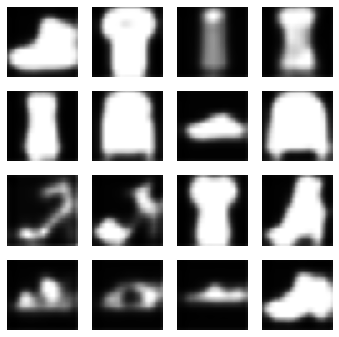

In [57]:
print('Model 1 with val loss = 0.027')
show_ae_images(aes[1])

Model 2 with val loss = 0.024


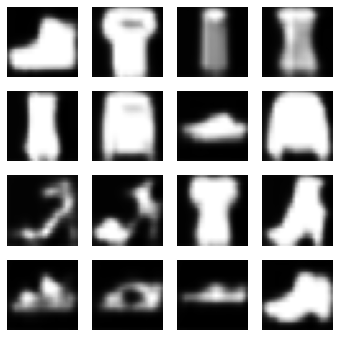

In [60]:
print('Model 2 with val loss = 0.024')
show_ae_images(aes[2])

Model 3 with val loss = 0.021


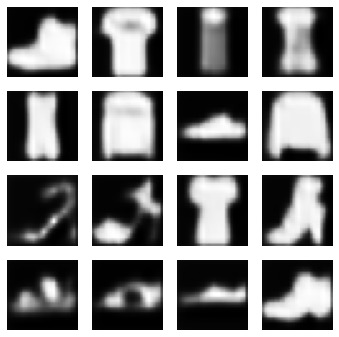

In [61]:
print('Model 3 with val loss = 0.021')
show_ae_images(aes[3])

Model 4 with val loss = 0.124


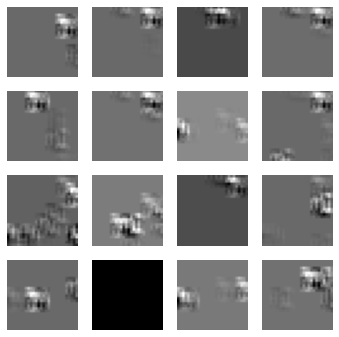

In [62]:
print('Model 4 with val loss = 0.124')
show_ae_images(aes[4])